In [ ]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

dtype = torch.float
device = torch.device("cpu")

In [ ]:
BATCH_SIZE = 124
LEARNING_RATE = 0.01
EPOCHS = 25

In [ ]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

## test data    
class TestData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
class BinaryClassification(nn.Module):
    def __init__(self, number_features, number_neurons):
        super(BinaryClassification, self).__init__()
        # Number of input features is 6.
        self.layer_1 = nn.Linear(number_features, number_neurons) 
        #self.layer_2 = nn.Linear(number_neurons, number_neurons)
        self.layer_out = nn.Linear(number_neurons, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(number_neurons)
        #self.batchnorm2 = nn.BatchNorm1d(number_neurons)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        #x = self.relu(self.layer_2(x))
        #x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
def TrainPhase(epochs, model, aggregated_losses, aggregated_accuracy, data_train, loss, optimizer):
    model.train()

    i = epochs
    #for i in range(1, epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in data_train:
        optimizer.zero_grad()
       
        y_pred = model(X_batch)
        
        single_loss = loss(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
            
        
        single_loss.backward()
        optimizer.step()
        
        epoch_loss += single_loss.item()
        epoch_acc += acc.item()
        
    aggregated_losses.append(epoch_loss/len(data_train))
    aggregated_accuracy.append((epoch_acc/len(data_train))/100)
    print(f'TRAIN - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_train):.5f} | Acc: {epoch_acc/len(data_train):.3f}')
    
    return model, aggregated_losses, aggregated_accuracy
        #i += 1
        #y_pred = model(data_train)

        #loss
        #single_loss = loss(y_pred, target_train.reshape(-1,1))
        #aggregated_losses.append(single_loss)
    
        #accuracy 
        #acc = binary_acc(y_pred, target_train.reshape(-1,1)) 
        #acc = (y_pred.reshape(-1).detach().numpy().round() == target_train).mean()
        #aggregated_accuracy.append(acc)

        #if i%25 == 1:
        #print(f'epoch: {i:3} loss: {single_loss.item():10.8f} accuracy: {acc/124:10.8f}')

        #optimizer.zero_grad()
        #single_loss.backward()
        #optimizer.step()

    #print(f'epoch: {i:3} loss: {single_loss.item():10.10f} accuracy: {acc:10.8f}')

    #return model, aggregated_losses, aggregated_accuracy

In [ ]:
def Evaluate(epochs, model, aggregated_losses, aggregated_accuracy, data_test, loss_f):
    
    i = epochs
    #for i in range(1, epochs+1):
    y_pred_list = []
    model.eval()
        
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for X_batch, y_batch in data_test:
            y_test_pred = model(X_batch)
            loss = loss_f(y_test_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_test_pred, y_batch.unsqueeze(1))
                
            epoch_loss += loss.item()
            epoch_acc += acc.item()

            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    aggregated_losses.append(epoch_loss/len(data_test))
    aggregated_accuracy.append((epoch_acc/len(data_test))/100)
    print(f'TEST - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f} | Acc: {epoch_acc/len(data_test):.3f}')
    
    return y_pred_list, aggregated_losses, aggregated_accuracy
    

## Loading MONK-1 dataset

In [ ]:
df_monk1_train = pd.read_csv('./data/MONK/monks-1.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_train.drop(labels='id', axis=1, inplace=True)

df_monk1_test = pd.read_csv('./data/MONK/monks-1.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk1_test.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1


In [ ]:
df_monk1_train

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1
...,...,...,...,...,...,...,...
119,1,3,3,2,1,4,2
120,1,3,3,2,3,1,2
121,1,3,3,2,3,2,2
122,1,3,3,2,3,3,2


<AxesSubplot:ylabel='class'>

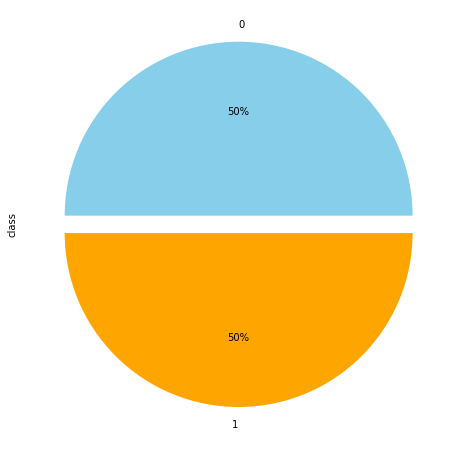

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk1_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

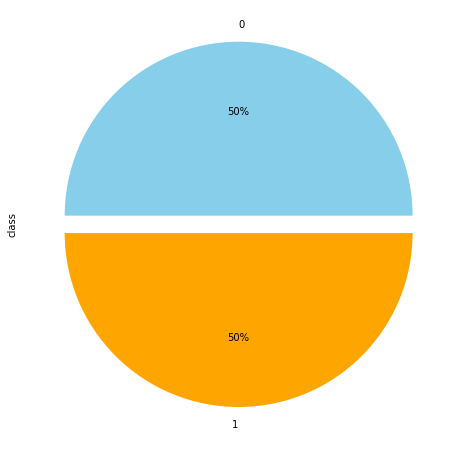

In [ ]:
df_monk1_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [ ]:
target_train = df_monk1_train.pop('class')
target_test = df_monk1_test.pop('class')
X_train = df_monk1_train
y_train = target_train
X_test = df_monk1_test
y_test = target_test

In [ ]:
y_train = y_train.values #returns a ndarray 
X_train = X_train.values #returns a ndarray
y_test = y_test.values
X_test = X_test.values
#y_train = y_train.ravel() #flattens the array into a 1-dimensional array
#y_test = y_test.ravel() #flattens the array into a 1-dimensional array

In [ ]:
train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

In [ ]:
test_data = TestData(torch.FloatTensor(X_test),
                     torch.FloatTensor(y_test))

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
#numerical_columns = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6']

#train_data = np.stack([df_monk1_train[col].values for col in numerical_columns], 1)
#train_data = torch.tensor(X_train, dtype=torch.float)
#train_data[:5]

In [ ]:
#test_data = np.stack([df_monk1_test[col].values for col in numerical_columns], 1)
#test_data = torch.tensor(X_test, dtype=torch.float)
#test_data[:5]

In [ ]:
#train_outputs = torch.tensor(y_train, dtype=torch.float).flatten()
#train_outputs[:10]

In [ ]:
#test_outputs = torch.tensor(y_test, dtype=torch.float).flatten()
#test_outputs[:10]

In [ ]:
model = BinaryClassification(X_train.shape[1], 4)
print(model.)

BinaryClassification(
  (layer_1): Linear(in_features=6, out_features=4, bias=True)
  (layer_out): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
#weights_layer1 = model.layer_1[0].weight.data # gets weights
#bias_layer1 = model.layer_1[0].bias.data # gets bias
print(model.parameters().__getattribute__)

<method-wrapper '__getattribute__' of generator object at 0x7f38e243e5d0>


In [ ]:
loss_function = nn.BCEWithLogitsLoss()
#loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
#model, losses, accuracies = TrainPhase(epochs, model, train_data, train_outputs, loss_function, optimizer)
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

for epoch in range(1,EPOCHS+1): 
  model, losses_train, accuracies_train = TrainPhase(epoch, model, losses_train, accuracies_train, train_loader, loss_function, optimizer)
  y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  print("##############################")


TRAIN - Epoch 001: | Loss: 0.92542 | Acc: 40.000
TEST - Epoch 001: | Loss: 0.73336 | Acc: 37.731
##############################
TRAIN - Epoch 002: | Loss: 0.92377 | Acc: 36.000
TEST - Epoch 002: | Loss: 0.72848 | Acc: 37.037
##############################
TRAIN - Epoch 003: | Loss: 0.87008 | Acc: 36.000
TEST - Epoch 003: | Loss: 0.72437 | Acc: 37.269
##############################
TRAIN - Epoch 004: | Loss: 0.84003 | Acc: 43.000
TEST - Epoch 004: | Loss: 0.72102 | Acc: 37.963
##############################
TRAIN - Epoch 005: | Loss: 0.82000 | Acc: 42.000
TEST - Epoch 005: | Loss: 0.71860 | Acc: 39.815
##############################
TRAIN - Epoch 006: | Loss: 0.78079 | Acc: 41.000
TEST - Epoch 006: | Loss: 0.71679 | Acc: 42.130
##############################
TRAIN - Epoch 007: | Loss: 0.77325 | Acc: 43.000
TEST - Epoch 007: | Loss: 0.71533 | Acc: 43.750
##############################
TRAIN - Epoch 008: | Loss: 0.74565 | Acc: 44.000
TEST - Epoch 008: | Loss: 0.71409 | Acc: 46.065
#######

In [ ]:
#plt.plot(range(EPOCHS), losses_train)
#plt.ylabel('Loss')
#plt.xlabel('epoch');

In [ ]:
#plt.plot(range(EPOCHS), accuracies_train)
#plt.ylabel('Accuracy')
#plt.xlabel('epoch');

In [ ]:
print(y_pred_test[:5])

[1.0, 1.0, 1.0, 0.0, 1.0]


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.57      0.48      0.52       216
           1       0.55      0.64      0.59       216

    accuracy                           0.56       432
   macro avg       0.56      0.56      0.55       432
weighted avg       0.56      0.56      0.55       432



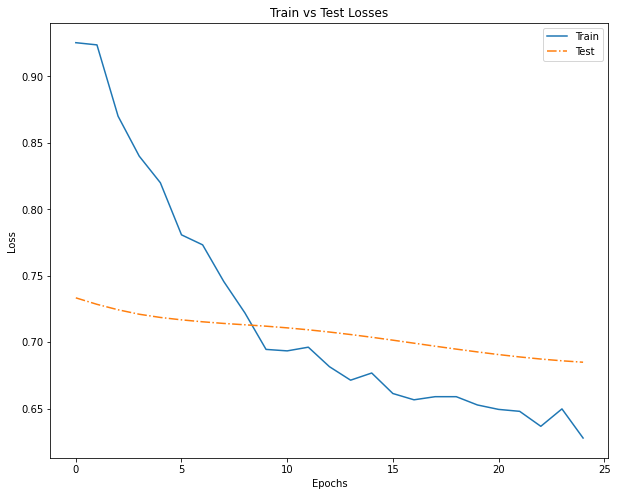

In [ ]:
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

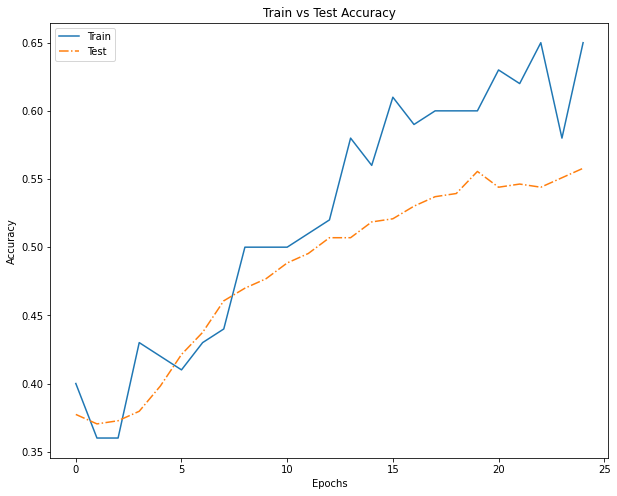

In [ ]:
plt.plot(accuracies_train,'-')
plt.plot(accuracies_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

### One hot encoding

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train)
X_train = enc_train.transform(X_train).toarray()
print(X_train.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test)
X_test = enc_test.transform(X_test).toarray()
print(X_test.shape)

(124, 17)
(432, 17)


In [ ]:
train_data_enc = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

In [ ]:
test_data_enc = TestData(torch.FloatTensor(X_test))

TypeError: __init__() missing 1 required positional argument: 'y_data'

In [ ]:
train_loader_enc = DataLoader(dataset=train_data_enc, batch_size=BATCH_SIZE, shuffle=True)
test_loader_enc = DataLoader(dataset=test_data_enc, batch_size=1)

In [ ]:
model_enc = BinaryClassification(X_test.shape[1], 4)
print(model_enc)

BinaryClassification(
  (layer_1): Linear(in_features=17, out_features=4, bias=True)
  (layer_2): Linear(in_features=4, out_features=4, bias=True)
  (layer_out): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
epochs = 100
model_enc, losses, accuracies = TrainPhase(epochs, model_enc, train_loader_enc, loss_function, optimizer)

Epoch 001: | Loss: 0.84043 | Acc: 52.000
Epoch 002: | Loss: 0.82659 | Acc: 53.000
Epoch 003: | Loss: 0.86207 | Acc: 48.000
Epoch 004: | Loss: 0.82099 | Acc: 53.000
Epoch 005: | Loss: 0.82120 | Acc: 55.000
Epoch 006: | Loss: 0.82320 | Acc: 52.000
Epoch 007: | Loss: 0.83153 | Acc: 54.000
Epoch 008: | Loss: 0.83789 | Acc: 49.000
Epoch 009: | Loss: 0.83537 | Acc: 53.000
Epoch 010: | Loss: 0.84548 | Acc: 48.000
Epoch 011: | Loss: 0.85291 | Acc: 49.000
Epoch 012: | Loss: 0.83183 | Acc: 53.000
Epoch 013: | Loss: 0.82439 | Acc: 52.000
Epoch 014: | Loss: 0.85216 | Acc: 52.000
Epoch 015: | Loss: 0.83691 | Acc: 49.000
Epoch 016: | Loss: 0.85105 | Acc: 52.000
Epoch 017: | Loss: 0.83646 | Acc: 51.000
Epoch 018: | Loss: 0.83892 | Acc: 51.000
Epoch 019: | Loss: 0.84705 | Acc: 51.000
Epoch 020: | Loss: 0.84533 | Acc: 50.000
Epoch 021: | Loss: 0.83261 | Acc: 53.000
Epoch 022: | Loss: 0.80788 | Acc: 52.000
Epoch 023: | Loss: 0.83538 | Acc: 53.000
Epoch 024: | Loss: 0.82221 | Acc: 52.000
Epoch 025: | Los

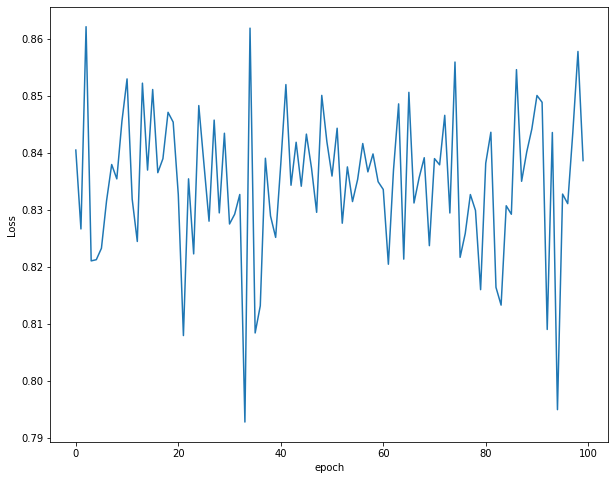

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

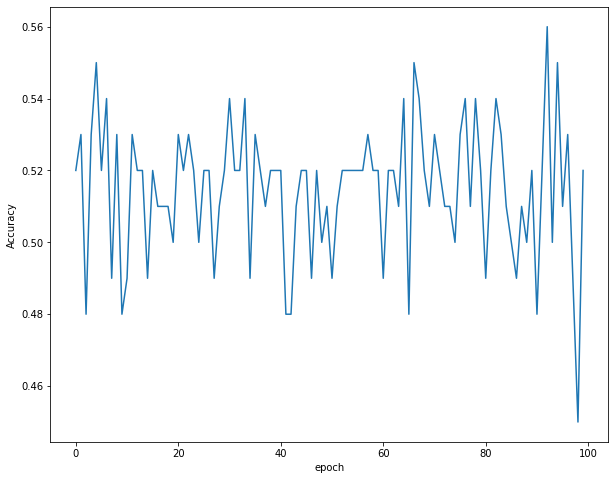

In [ ]:
plt.plot(range(epochs), accuracies)
plt.ylabel('Accuracy')
plt.xlabel('epoch');

In [ ]:
y_pred_test = Evaluate(model_enc, test_loader_enc)
print(y_pred_test[:5])

[1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.53      0.38      0.44       216
           1       0.52      0.67      0.58       216

    accuracy                           0.52       432
   macro avg       0.53      0.52      0.51       432
weighted avg       0.53      0.52      0.51       432



### Loading MONK-2 dataset

In [ ]:
df_monk2_train = pd.read_csv('./data/MONK/monks-2.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_train.drop(labels='id', axis=1, inplace=True)

df_monk2_test = pd.read_csv('./data/MONK/monks-2.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk2_test.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,1,1
1,0,1,1,1,1,1,2
2,0,1,1,1,1,2,1
3,0,1,1,1,1,2,2
4,0,1,1,1,1,3,1


In [ ]:
df_monk2_train

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,2,2
1,0,1,1,1,1,4,1
2,0,1,1,1,2,1,1
3,0,1,1,1,2,1,2
4,0,1,1,1,2,2,1
...,...,...,...,...,...,...,...
164,0,3,3,2,2,3,1
165,0,3,3,2,2,3,2
166,1,3,3,2,3,1,1
167,0,3,3,2,3,2,1


<AxesSubplot:ylabel='class'>

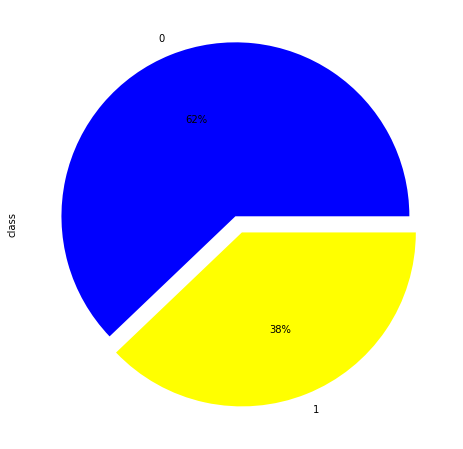

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk2_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

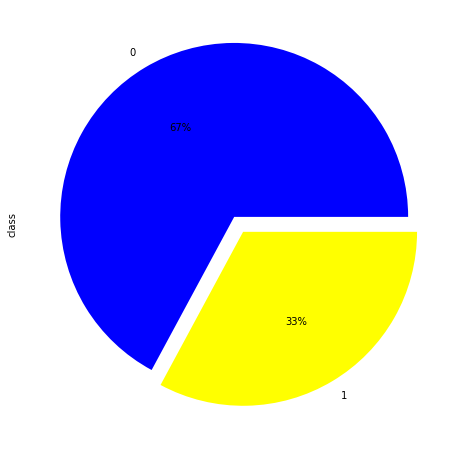

In [ ]:
df_monk2_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

In [ ]:
target_train = df_monk2_train.pop('class')
target_test = df_monk2_test.pop('class')
X_train = df_monk2_train
y_train = target_train
X_test = df_monk2_test
y_test = target_test

In [ ]:
y_train = y_train.values #returns a ndarray 
X_train = X_train.values #returns a ndarray
y_test = y_test.values
X_test = X_test.values

In [ ]:
train_data = torch.tensor(X_train, dtype=torch.float)
train_data[:5]

tensor([[1., 1., 1., 1., 2., 2.],
        [1., 1., 1., 1., 4., 1.],
        [1., 1., 1., 2., 1., 1.],
        [1., 1., 1., 2., 1., 2.],
        [1., 1., 1., 2., 2., 1.]])

In [ ]:
test_data = torch.tensor(X_test, dtype=torch.float)
test_data[:5]

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 2.],
        [1., 1., 1., 1., 2., 1.],
        [1., 1., 1., 1., 2., 2.],
        [1., 1., 1., 1., 3., 1.]])

In [ ]:
train_outputs = torch.tensor(y_train, dtype=torch.float).flatten()
train_outputs[:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
test_outputs = torch.tensor(y_test, dtype=torch.float).flatten()
test_outputs[:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
model = NeuralNetwork(train_data.shape[1])
print(model)

NameError: name 'NeuralNetwork' is not defined

In [ ]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 350
model, losses, accuracies = TrainPhase(epochs, model, train_data, target_train, loss_function, optimizer)

epoch:   1 loss: 0.67045152 accuracy: 0.62130178
epoch:  26 loss: 0.65504378 accuracy: 0.62130178
epoch:  51 loss: 0.64348972 accuracy: 0.61538462
epoch:  76 loss: 0.62864619 accuracy: 0.65680473
epoch: 101 loss: 0.60579801 accuracy: 0.65680473
epoch: 126 loss: 0.57451189 accuracy: 0.71597633
epoch: 151 loss: 0.53560650 accuracy: 0.76923077
epoch: 176 loss: 0.48799345 accuracy: 0.81065089
epoch: 201 loss: 0.43314528 accuracy: 0.85207101
epoch: 226 loss: 0.37758410 accuracy: 0.86982249
epoch: 251 loss: 0.32909244 accuracy: 0.90532544
epoch: 276 loss: 0.28351125 accuracy: 0.92307692
epoch: 301 loss: 0.24147016 accuracy: 0.92899408
epoch: 326 loss: 0.20468555 accuracy: 0.95857988
epoch: 350 loss: 0.1737452894 accuracy: 0.98224852


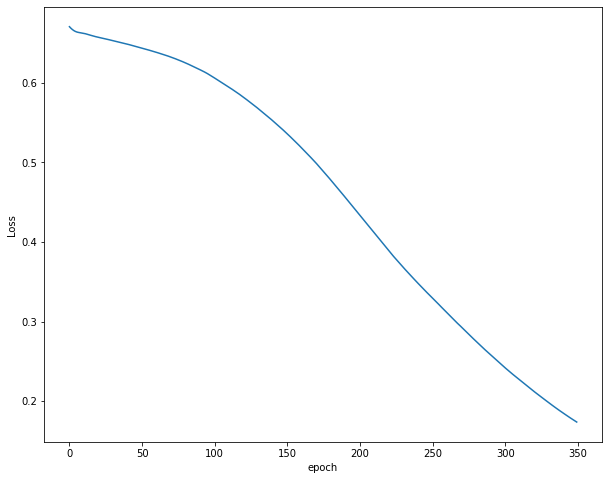

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

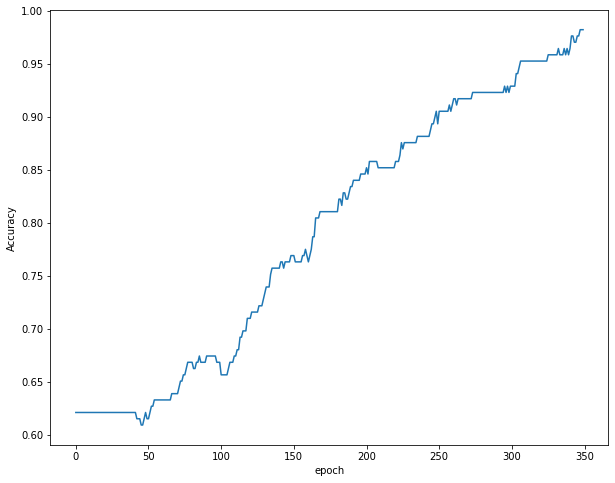

In [ ]:
plt.plot(range(epochs), accuracies)
plt.ylabel('Accuracy')
plt.xlabel('epoch');

In [ ]:
y_pred_test = Evaluate(model, test_data, loss_function)

Loss: 0.56764388


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>